<a href="https://colab.research.google.com/github/alvinrach/Multiclass-Animal-Image-Checkpoint_Callback-TFLite/blob/main/Copy_3_of_CNN_TFLite_Chicken_Spider_Dog_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Alvin Rachmat**

**Convolutional Neural Network with TFLite : Chicken-Spider-Dog Prediction**

In [ ]:
!mkdir -p ~/.kaggle
!echo '{"username":"alvinrach","key":"01d0bc7e09928966a5b93eabab748737"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10

 99% 578M/586M [00:05<00:00, 97.4MB/s]
100% 586M/586M [00:05<00:00, 108MB/s] 


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

In [ ]:
tpu = False

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

if tpu:
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)

from tensorflow.keras.applications import ResNet152V2

In [ ]:
import translate
translate.translate

{'butterfly': 'farfalla',
 'cane': 'dog',
 'cat': 'gatto',
 'cavallo': 'horse',
 'chicken': 'gallina',
 'cow': 'mucca',
 'dog': 'cane',
 'elefante': 'elephant',
 'elephant': 'elefante',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'scoiattolo': 'squirrel',
 'spider': 'ragno',
 'squirrel': 'scoiattolo'}

In [ ]:
a={'cane': 'dog',
 'cavallo': 'horse',
 'elefante': 'elephant',
 'farfalla': 'butterfly',
 'gallina': 'chicken',
 'gatto': 'cat',
 'mucca': 'cow',
 'pecora': 'sheep',
 'scoiattolo': 'squirrel',
 'ragno': 'spider'}

In [ ]:
img_path = '/content/raw-img/'
for i in os.listdir(img_path):
  try:
    os.rename(img_path+i, img_path+a[i])
  except:
    continue

In [ ]:
a = [name for name in os.listdir(img_path)]
a

['spider', 'dog', 'chicken']

In [ ]:
print('Labels Count')
z=len(os.listdir(img_path))
z

Labels Count


3

In [ ]:
print('Images Count')
b = 0
for i in os.listdir(img_path):
  print(i)
  print(len(os.listdir(img_path+i)))
  print('\n')
  c = len(os.listdir(img_path+i))
  b+=c
print('Total Count')
b

Images Count
spider
4821


dog
4863


chicken
3098


Total Count


12782

In [ ]:
# For simplification of the model, get the highet 3 labels counts
import shutil
b=['cow',
 'cat',
 'butterfly',
 'sheep',
 'horse',
 'elephant',
 'squirrel']

for i in b:
  try:
    shutil.rmtree(img_path+i)
  except:
    continue

In [ ]:
print('Images Count')
b = 0
for i in os.listdir(img_path):
  print(i)
  print(len(os.listdir(img_path+i)))
  print('\n')
  c = len(os.listdir(img_path+i))
  b+=c
print('Total Count')
b

Images Count
spider
4821


dog
4863


chicken
3098


Total Count


12782

In [ ]:
print('Labels Count')
z=len(os.listdir(img_path))
z

Labels Count


3

In [ ]:
img_path+i+'/'+os.listdir(img_path+i)[0]

'/content/raw-img/chicken/410.jpeg'

Images with various pixel size


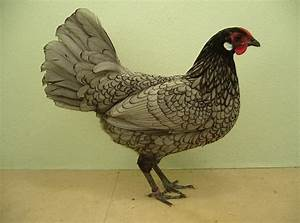

In [ ]:
print('Images with various pixel size')
from IPython.display import Image
Image(img_path+i+'/'+os.listdir(img_path+i)[1])

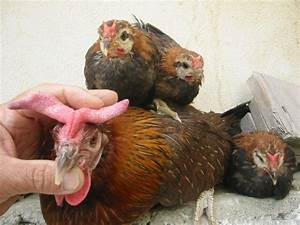

In [ ]:
Image(img_path+i+'/'+os.listdir(img_path+i)[2])

In [ ]:
target_img = (128,128)
batch = 64
set_seed = 100

datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    # vertical_flip=True,
                    # width_shift_range=0.2,
                    # height_shift_range=0.2,
                    # shear_range = 0.2,
                    zoom_range=0.2,
                    brightness_range=[0.9,1.0],
                    fill_mode = 'nearest',
                    validation_split=0.2
                    )

train_generator = datagen.flow_from_directory(
        img_path,
        target_size=target_img,
        batch_size=batch,
        class_mode='categorical',
        subset='training',
        seed=set_seed
        )

datagenval = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.2
                    )

validation_generator = datagenval.flow_from_directory(
        img_path,
        target_size=target_img,
        batch_size=batch,
        class_mode='categorical',
        subset='validation',
        seed=set_seed
        )

Found 10227 images belonging to 3 classes.
Found 2555 images belonging to 3 classes.


In [ ]:
def get_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer((*target_img,3)),
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),

      # ResNet152V2(weights="imagenet", include_top=False),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(z, activation='softmax')
  ])

  # model.layers[0].trainable = True

  model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',#tf.keras.optimizers.Adam(learning_rate=5e-01),
    metrics=['categorical_accuracy']
  )

  return model

In [ ]:
if tpu:
  with tpu_strategy.scope():
    model = get_model()
  print('TPU activated on model')
  # batch_size = tpu_strategy.num_replicas_in_sync * 32
else: 
  model = get_model()
  print('TPU not activated on model')
  # batch_size = 32

# train_steps = y_train.shape[0] // batch_size

TPU not activated on model


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       7

In [ ]:
early = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model.h5',
    monitor = 'val_categorical_accuracy',
    save_best_only = True,
    verbose = 1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy',
    patience = 10,
    factor = 0.1,
    min_lr = 1e-6,
    verbose = 1
)

set_callback = [checkpoint, reduce_lr, early]

history = model.fit(
      train_generator,
      epochs = 100,
      validation_data=validation_generator,
      callbacks=[set_callback],
      verbose = 1
      )

Epoch 1/100
160/160 [==============================] - 76s 453ms/step - loss: 1.0630 - categorical_accuracy: 0.4075 - val_loss: 0.9058 - val_categorical_accuracy: 0.5816

Epoch 00001: val_categorical_accuracy improved from -inf to 0.58160, saving model to model.h5
Epoch 2/100
160/160 [==============================] - 71s 444ms/step - loss: 0.8022 - categorical_accuracy: 0.6392 - val_loss: 0.8155 - val_categorical_accuracy: 0.6286

Epoch 00002: val_categorical_accuracy improved from 0.58160 to 0.62857, saving model to model.h5
Epoch 3/100
160/160 [==============================] - 71s 445ms/step - loss: 0.5844 - categorical_accuracy: 0.7614 - val_loss: 0.4379 - val_categorical_accuracy: 0.8337

Epoch 00003: val_categorical_accuracy improved from 0.62857 to 0.83366, saving model to model.h5
Epoch 4/100
160/160 [==============================] - 72s 451ms/step - loss: 0.4290 - categorical_accuracy: 0.8390 - val_loss: 0.5544 - val_categorical_accuracy: 0.7949

Epoch 00004: val_categorical

In [ ]:
model.evaluate(validation_generator)

40/40 [==============================] - 5s 116ms/step - loss: 0.3147 - categorical_accuracy: 0.9307


[0.3146873712539673, 0.9307240843772888]

In [ ]:
model.load_weights("model.h5")
model.evaluate(validation_generator)

40/40 [==============================] - 5s 117ms/step - loss: 0.2409 - categorical_accuracy: 0.9382


[0.24088738858699799, 0.9381604790687561]

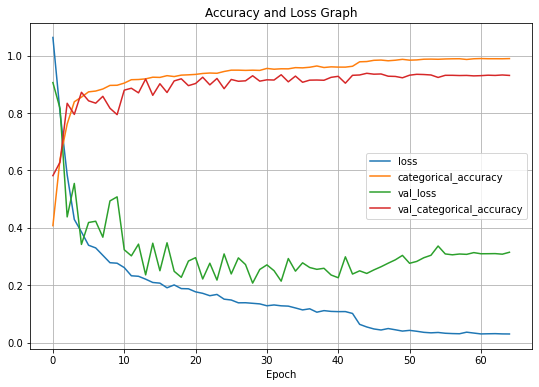

In [ ]:
# Plotting loss and accuracy, train and validation, each epoch
history.history.pop('lr')

import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(9,6))
plt.xlabel('Epoch')
plt.title('Accuracy and Loss Graph')
plt.grid()

In [ ]:
# Save model to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp219opmt1/assets
